# Восстановление золота из руды

Компания «Цифры» разрабатывает решения для эффективной работы промышленных предприятий. Необходимо подготовить модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении имеются данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Порядок работы:

1. Подготовка данных;
2. Исследовательский анализ данных;
3. Построение и обучение модели.

## Подготовка данных

### Импорт библиотек

Перед подготовкой данных импортируем необходимые библиотеки и модули:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale

Сохраним исходные датасеты в соответствующих датасетах:

In [2]:
train_data = pd.read_csv('/datasets/gold_recovery_train_new.csv') # обучающая выборка

In [3]:
test_data = pd.read_csv('/datasets/gold_recovery_test_new.csv')   # тестовая выборка

In [4]:
full_data = pd.read_csv('/datasets/gold_recovery_full_new.csv')   # исходные данные

После загрузки датасетов, посмотрим первые строчки каждого датасета и агрегированные данные по ним.

### Обучающая выборка

In [5]:
train_data.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Всего в датасете 87 столбцов - из них один имеет тип данных "object" — дата процесса обработки, и 86 являются числовыми. В зависимости от этапа, который характеризует признак, его имя начинается с `rougher` — флотация, `primary_cleaner` — первая очистка, `secondary_cleaner` — вторая очистка или `final` — финальный продукт.

Второй частью имени столбца т.е. признака является тип параметра. Тип может приобретать следующие значения:
- `input` — параметр вводного продукта, т.е. сырья для данного этапа;
- `output` — параметр конечного продукта этапа;
- `state` — параметры, характеризующие текущее состояние этапа;
- `calculation` — расчётные характеристики.
    

Отметим, что в признаках имеются пропуски — где-то их почти нет (`final.output.concentrate_ag` имеет один пропуск), где-то их доля относительно высока (`rougher.input.floatbank11_xanthate`).

Целевыми признаками являются эффективность обогащения чернового концентрата `rougher.output.recovery` и эффективность обогащения финального концентрата `final.output.recovery`.


In [7]:
train_data.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


Отметим, что у признаков разный масштаб — для применения моделей машинного обучения может потребоваться нормализация данных.

### Тестовая выборка

In [8]:
test_data.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Количество стобцов в тестовой выборке значительно меньше — вместо 86 признаков, мы имеем только 52 признака. Посмотрим, что за признаки отсутствуют.

In [10]:
print(len(set(train_data) - set(test_data.columns))) # количество отсутствующих признаков
set(train_data) - set(test_data.columns)             # преобразуем название признаков во множества
                                                     # и найдем их разницу

34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутсвуют целевые признаки, а также все что связано с содержанием различных элементов в продуктах каждого этапа — т.е. фактически для всех этапов отсутствуют признаки с названием `[].output.[]` (например, `primary_cleaner.output.tail_au` — содержание серебра в хвостах после первичной очистки). Кроме того, отсутсуют расчетные метрики для этапа флотации `rougher.calculation`. Вероятно, по задумке тех, кто отделял тестовую выборку, это позволяет исключить подглядывание продуктов при прогнозировании. Остутствие расчетных метрик, вероятно, связано с тем, чтобы они не известны до начала процесса — т.е. они относятся к онлайн-метрикам — и передавать их для обучения моделей бессмысленно. 

In [11]:
test_data.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


Отметим, что по некоторым признакам в тренировчной и тестовой выборке отличаются статистические параметры. Например, у признака `primary_cleaner.input.sulfate` в тестовой выборке дисперсия равняется `43`, среднее значение `174.8` и медиана — `177.8`, — а в тренировочной, `39.4 , 133.3 , 133.01` соответственно.

Такие различия могут быть связаны с тем, что выборки собирались в разное время, а смесь золотосодержащей руды имеет крайне не постоянные характеристики. Различие характеристик может затруднить обучение моделей.

In [12]:
train_data['primary_cleaner.input.sulfate'].describe()

count    14129.000000
mean       133.320659
std         39.431659
min          0.003112
25%        107.006651
50%        133.018328
75%        159.825396
max        250.127834
Name: primary_cleaner.input.sulfate, dtype: float64

Отметим, что проверка работы модели потребует присоединения целевых признаков из полного датасета `full_data` по дате.

Также заметим, что в тестовой выборке почти отсутствуют пропуски.

### Полный набор данных

In [13]:
full_data.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [14]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


В полном датасете имеются все те же признаки, что в тестовой выборке — не больше, не меньше. Сравним статистические данные на примере одного признака, разницу по которому уже заметили в тестовой и тренировочной выборке.

In [15]:
full_data['primary_cleaner.input.sulfate'].describe()

count    19415.000000
mean       144.624774
std         44.464071
min          0.003112
25%        114.107029
50%        143.232103
75%        175.075656
max        265.983123
Name: primary_cleaner.input.sulfate, dtype: float64

In [16]:
train_data['primary_cleaner.input.sulfate'].describe()

count    14129.000000
mean       133.320659
std         39.431659
min          0.003112
25%        107.006651
50%        133.018328
75%        159.825396
max        250.127834
Name: primary_cleaner.input.sulfate, dtype: float64

In [17]:
test_data['primary_cleaner.input.sulfate'].describe()

count    5286.000000
mean      174.839652
std        43.027080
min         2.566156
25%       147.121401
50%       177.828489
75%       208.125438
max       265.983123
Name: primary_cleaner.input.sulfate, dtype: float64

В статистических параметрах есть некоторые различия — это ожидаемо для выборок, но тем не менее может затруднять обучение моделей.

Проверим, сможем ли мы "выцепить" необходимый целевой признак по дате для тестовой выборке на примере первой строки `test_data`.

In [18]:
full_data[full_data['date'] == '2016-09-01 00:59:59']['final.output.recovery'] #значение даты из первой
                                                                               #строки test_data

4682    70.273583
Name: final.output.recovery, dtype: float64

Успех.

### Проверка расчетов эффективности обогащения 

Перед продолжением исследования, проверим правильно ли рассчитана эффективность обогащения — вычислим ее на обучающей выборке для признака `rougher.output.recovery`.

Формула эффективности обогащения `recovery`:

`recovery` = (`C` * (`F` - `T`)) **/** ( `F`* (`C` - `T`)) * 100%

где:
- `C` — доля золота в концентрате после этапа обработки (флотации или очистки);
- `F` — доля золота в концентрате до этапа обработки;
- `T` — доля золота в отваленных хвостах на этапе.

В тестовой выборке:
- `C` — `rougher.output.concentrate_au`
- `F` — `rougher.input.feed_au`
- `T` — `rougher.output.tail_au`

- `recovery` — `rougher.output.recovery`.

Для расчетов будем использовать строки, в которых не имеется пропусков в необходимых признаках:

In [19]:
# создаем вспомогательный датасет, т.к. мы еще не обработали пропуски

calculated_data = train_data.dropna(subset = ['rougher.output.concentrate_au',
                                              'rougher.input.feed_au',
                                              'rougher.output.tail_au',
                                              'rougher.output.recovery'])

In [20]:
C = calculated_data['rougher.output.concentrate_au'] #временные переменные для удобства расчета
F = calculated_data['rougher.input.feed_au']
T = calculated_data['rougher.output.tail_au']

calculated_recovery = (C*(F-T))/(F*(C-T))*100

In [21]:
calculated_recovery # проверяем расчеты

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

Для оценки корректности расчета метрики используем среднее абсолютное отклонение MAE. 

In [22]:
mean_absolute_error(calculated_data['rougher.output.recovery'],calculated_recovery)

9.73512347450521e-15

 ~ `0.0000000000000097` — MAE стремится к нулю, а значит `rougher.output.recovery` рассчитана верно.

### Проверка на явные дубликаты

In [23]:
test_data.duplicated().sum()

0

In [24]:
train_data.duplicated().sum()

0

In [25]:
full_data.duplicated().sum()

0

Явных дубликатов нет.

### Присоединение целевых признаков

В тестовой выборке нет целевых признаков `rougher.output.recovery` и `final.output.recovery`, что осложнит проверку работы модели. Восстановим признаки, присоединив к выборке необходимые столбцы по дате.

In [26]:
test_data.shape #проверяем размерность выборки до присоединения

(5290, 53)

In [27]:
test_data = test_data.merge(full_data[['date','rougher.output.recovery','final.output.recovery']],
                            on = 'date', how = 'inner')

In [28]:
test_data.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


In [29]:
test_data.shape

(5290, 55)

Размерность увеличилась с 53 до 55 признаков.

### Обработка пропусков и аномалий

Посмотрим на распределение целевых признаков `rougher.output.recovery` и `final.output.recovery` в тренировочной выборкe:

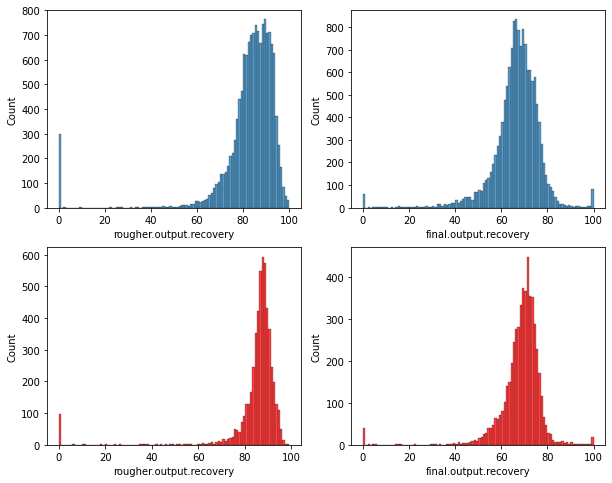

In [30]:
fig = plt.figure(figsize=(10,8))
ax_1 = fig.add_subplot(2,2,1)
ax_2 = fig.add_subplot(2,2,2)
ax_3 = fig.add_subplot(2,2,3)
ax_4 = fig.add_subplot(2,2,4)

sns.histplot(train_data['rougher.output.recovery'], bins=100, ax=ax_1)
sns.histplot(train_data['final.output.recovery'], bins=100, ax=ax_2)
sns.histplot(test_data['rougher.output.recovery'], bins=100, color='red', ax=ax_3)
sns.histplot(test_data['final.output.recovery'], bins=100, color='red', ax=ax_4)



plt.show()


График `rougher.output.recovery` имеет аномальный всплеск значений у нуля. Посмотрим на эти объекты.

In [31]:
train_data[train_data['rougher.output.recovery']==0] #в обучающей выборке

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,...,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,...,14.094808,-550.676337,12.004728,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,NaN,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,2016-01-17 02:00:00,8.162896,8.877528,NaN,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,...,13.984906,-550.563329,11.999730,-550.549773,9.941869,-503.282068,8.018850,-500.970716,11.991078,-598.475929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10330,2018-02-11 23:59:59,4.909904,9.941006,8.191698,47.660737,83.597741,8.853800,0.717677,13.399798,1.515512,...,19.999169,-502.266441,14.943901,-500.386063,10.998883,-499.846204,8.972741,-500.118532,10.966205,-500.707126
10331,2018-02-12 00:59:59,4.797572,9.889303,8.326773,47.801056,84.738648,8.503813,0.757507,13.591903,1.573222,...,19.961164,-499.274851,14.950879,-499.891798,11.010768,-494.562898,9.028307,-499.007596,10.978016,-497.924873
10332,2018-02-12 01:59:59,4.329492,9.413122,8.173988,49.412576,73.519948,8.846540,1.479231,13.094763,2.760905,...,20.013736,-499.502171,14.957857,-499.873967,11.034954,-493.250025,9.029441,-480.953533,11.021042,-499.685577
10333,2018-02-12 02:59:59,4.317169,9.642271,8.396492,48.839994,78.415342,8.485093,1.155559,13.380461,2.198065,...,20.013476,-500.511253,14.964835,-500.084773,10.972473,-511.806312,8.991251,-500.706169,10.990072,-499.775802


Нулевые значения могли быть вызваны как ошибкой учета, так и технологическими особенностями процесса — например, запуском флотационной установки без руды для промывки прибора.

У второго целевого признака `final.output.recovery` имеются два всплеска - около 0 и около 100.

**Важно**: рисунок графиков на тестовой выборке повторяет рисунки обучающей выборки с соответствующими всплесками — учитывая это, даже если появление этих аномальных значений вызвано ошибкой учета или технологическими особенностями, модель должна их предсказать т.к. имеет соответвующие объекты для обучения.

## Анализ данных

### Концентрация металлов на различных этапах очистки

В руде и последущих концентратах, передающихся с этапа на этап, содержится не только золото, но также серебро и свинец. Посмотрим как меняются их концентрации после каждого этапа.

#### Концентрация золота

Концентрацию золота отражают следующие признаки: 
- `rougher.output.concentrate_au`,
- `primary_cleaner.output.concentrate_au`,
- `final.output.concentrate_au`.

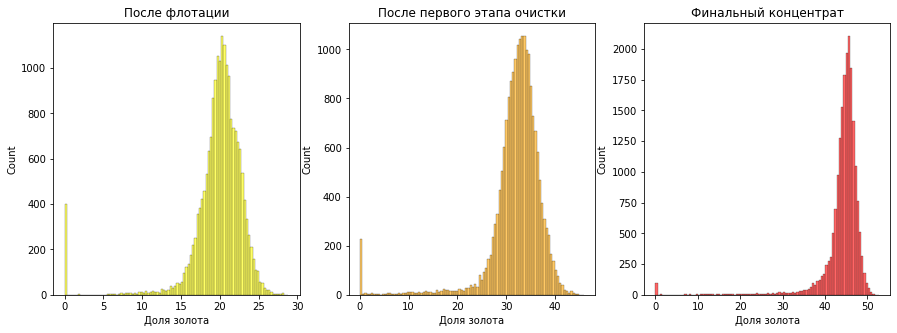

In [32]:
fig = plt.figure(figsize=([15,5]))

ax_1 = fig.add_subplot(1,3,1)
ax_2 = fig.add_subplot(1,3,2)
ax_3 = fig.add_subplot(1,3,3)

sns.histplot(full_data['rougher.output.concentrate_au'], bins=100, alpha=0.6, color='yellow', ax = ax_1)
sns.histplot(full_data['primary_cleaner.output.concentrate_au'], bins=100, alpha=0.6, color='orange', ax = ax_2)
sns.histplot(full_data['final.output.concentrate_au'], bins=100, alpha=0.6, color='red', ax = ax_3)

ax_1.set_title('После флотации')
ax_1.set_xlabel('Доля золота')
ax_2.set_title('После первого этапа очистки')
ax_2.set_xlabel('Доля золота')
ax_3.set_title('Финальный концентрат')
ax_3.set_xlabel('Доля золота')
plt.show()

Доля золота растет от этапа к этапу, что логично, т.к. это и является целью технологочисеского процесса. Если после флотации средняя доля равняется примерно 20%, то к завершению процесса она достигает уже 45%.

Для наглядности динамики изменения концентрации золота, выведем графики на одном графике:

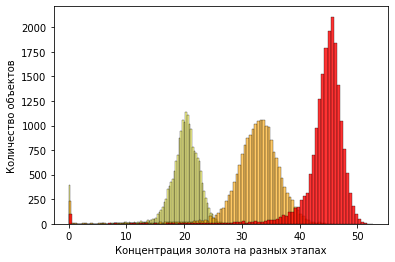

In [33]:
fig, ax = plt.subplots()

sns.histplot(full_data['rougher.output.concentrate_au'], bins=100, alpha=0.4, color='yellow')
sns.histplot(full_data['primary_cleaner.output.concentrate_au'], bins=100, alpha=0.6, color='orange')
sns.histplot(full_data['final.output.concentrate_au'], bins=100, alpha=0.8, color='red')

ax.set_xlabel('Концентрация золота на разных этапах')
ax.set_ylabel('Количество объектов')

plt.show()

#### Концентрация серебра

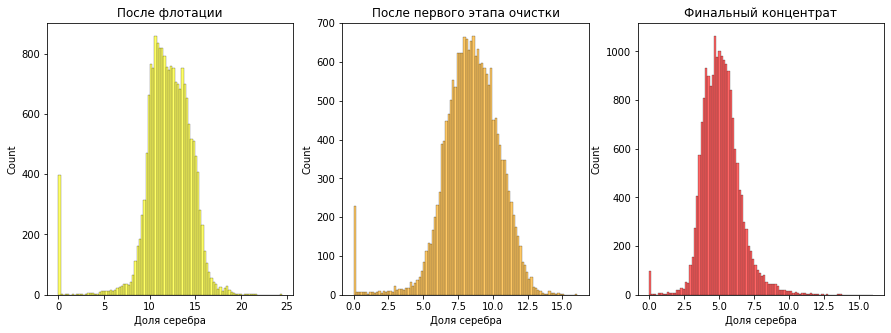

In [34]:
fig = plt.figure(figsize=([15,5]))

ax_1 = fig.add_subplot(1,3,1)
ax_2 = fig.add_subplot(1,3,2)
ax_3 = fig.add_subplot(1,3,3)

sns.histplot(full_data['rougher.output.concentrate_ag'], bins=100, alpha=0.6, color='yellow', ax = ax_1)
sns.histplot(full_data['primary_cleaner.output.concentrate_ag'], bins=100, alpha=0.6, color='orange', ax = ax_2)
sns.histplot(full_data['final.output.concentrate_ag'], bins=100, alpha=0.6, color='red', ax = ax_3)

ax_1.set_title('После флотации')
ax_1.set_xlabel('Доля серебра')
ax_2.set_title('После первого этапа очистки')
ax_2.set_xlabel('Доля серебра')
ax_3.set_title('Финальный концентрат')
ax_3.set_xlabel('Доля серебра')

plt.show()

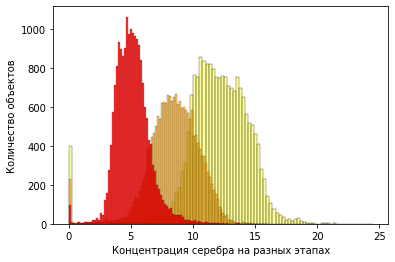

In [40]:
fig, ax = plt.subplots()

sns.histplot(full_data['rougher.output.concentrate_ag'], bins=100, alpha=0.4, color='yellow')
sns.histplot(full_data['primary_cleaner.output.concentrate_ag'], bins=100, alpha=0.6, color='orange')
sns.histplot(full_data['final.output.concentrate_ag'], bins=100, alpha=0.8, color='red')

ax.set_xlabel('Концентрация серебра на разных этапах')
ax.set_ylabel('Количество объектов')

plt.show()

Концентрация серебра, напротив, снижается от этапа к этапу - средняя доля падает с 11% до 5%

#### Концентрация свинца

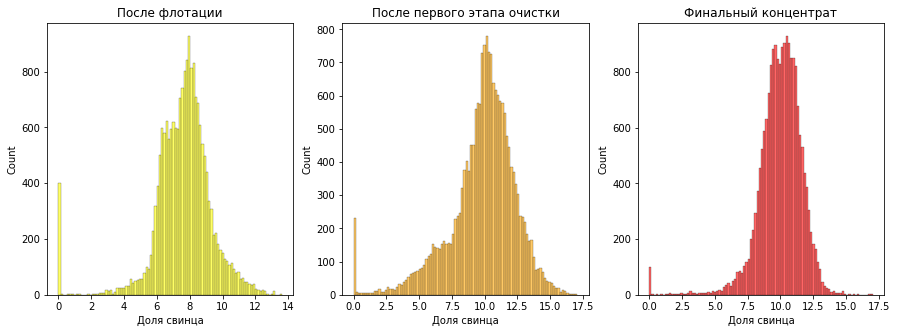

In [35]:
fig = plt.figure(figsize=([15,5]))

ax_1 = fig.add_subplot(1,3,1)
ax_2 = fig.add_subplot(1,3,2)
ax_3 = fig.add_subplot(1,3,3)

sns.histplot(full_data['rougher.output.concentrate_pb'], bins=100, alpha=0.6, color='yellow', ax = ax_1)
sns.histplot(full_data['primary_cleaner.output.concentrate_pb'], bins=100, alpha=0.6, color='orange', ax = ax_2)
sns.histplot(full_data['final.output.concentrate_pb'], bins=100, alpha=0.6, color='red', ax = ax_3)

ax_1.set_title('После флотации')
ax_1.set_xlabel('Доля свинца')
ax_2.set_title('После первого этапа очистки')
ax_2.set_xlabel('Доля свинца')
ax_3.set_title('Финальный концентрат')
ax_3.set_xlabel('Доля свинца')

plt.show()

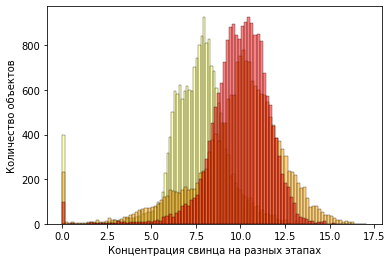

In [36]:
fig, ax = plt.subplots()

sns.histplot(full_data['rougher.output.concentrate_pb'], bins=100, alpha=0.3, color='yellow')
sns.histplot(full_data['primary_cleaner.output.concentrate_pb'], bins=100, alpha=0.5, color='orange')
sns.histplot(full_data['final.output.concentrate_pb'], bins=100, alpha=0.5, color='red')

ax.set_xlabel('Концентрация свинца на разных этапах')
ax.set_ylabel('Количество объектов')

plt.show()

Со свинцом картина несколько иная — сначала доля этого металла сокращается, а далее - усредняяется (пик у среднего значения вырастает). Вероятно это связано с тем, что свинец отделяется только на этапе флотации — а из-за снижения доли других элементов (например, серебра), его доля растет.

### Распределение размеров гранул сырья на обучающей и тестовой выборках

Перед обучением модели стоит также проверить распределение размеров гранул сырья (`feed_size`) на обучающей и тестовой выборках. На этапе подготовки данных мы отметили, что у некоторых признаков в них отличаются средние и дисперсии — разница в этом параметре может привести к ошибке обучения.

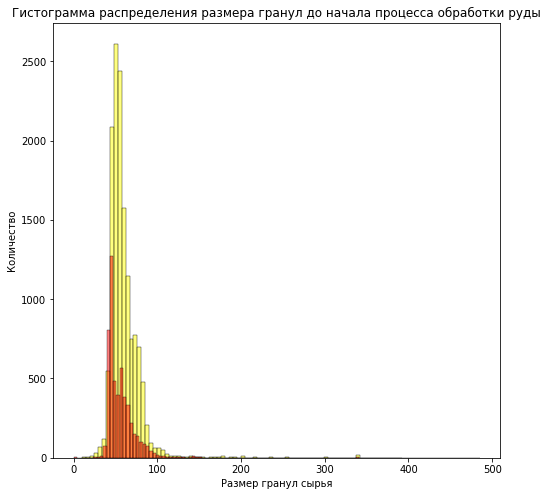

In [37]:
plt.figure(figsize=[8,8])

sns.histplot(train_data['rougher.input.feed_size'], bins=100, color='yellow', alpha=0.5)
sns.histplot(test_data['rougher.input.feed_size'], bins=100, color='red', alpha=0.5)

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество")

plt.title("Гистограмма распределения размера гранул до начала процесса обработки руды")
plt.show()

Повторим график, указав доли вместо объектов, вместо абсолюного значения

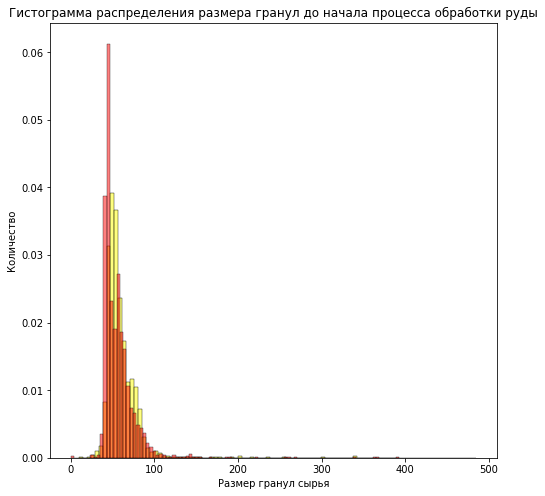

In [38]:
plt.figure(figsize=[8,8])

sns.histplot(train_data['rougher.input.feed_size'], bins=100, color='yellow', alpha=0.5, stat= 'density' )
sns.histplot(test_data['rougher.input.feed_size'], bins=100, color='red', alpha=0.5, stat= 'density')

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество")

plt.title("Гистограмма распределения размера гранул до начала процесса обработки руды")
plt.show()

В обоих выборках распределение размеров грапнул сырья похоже на нормальное со смещением влево, правда в обучающей выборке среднее значение чуть выше. 

Отметим, что на графике видны выбросы из-за которых график растянулся вправо по оси X до 500.

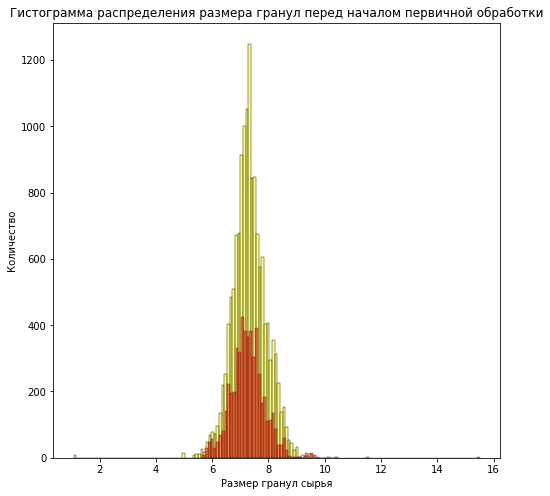

In [39]:
plt.figure(figsize=[8,8])

sns.histplot(train_data['primary_cleaner.input.feed_size'], bins=100, color='yellow', alpha=0.5)
sns.histplot(test_data['primary_cleaner.input.feed_size'], bins=100, color='red', alpha=0.5)

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество")

plt.title("Гистограмма распределения размера гранул перед началом первичной обработки")
plt.show()

После флотации размер гранул уменьшается, а распределение в обоих выборках становится нормальным — флотация позволяет избавиться от выбросов и нетипичного сырья. Таким образом, модель должна обучиться правильно.

### Суммарная концентрация веществ на всех этапах

Анализ суммарной концентрации веществ в руде на разных этапах позволит выявить в данных аномалии.

К веществам мы отнесем Au, Aq, Pb, Sol. Произведем расчет их общей концентрации.

In [46]:
# перед флотацией

rougher_total_feed_train = (train_data['rougher.input.feed_au'] +
                            train_data['rougher.input.feed_ag'] +
                            train_data['rougher.input.feed_pb'] +
                            train_data['rougher.input.feed_sol'])

# на этапе флотации
    
rougher_total_concentrate_train = (train_data['rougher.output.concentrate_au'] +
                                   train_data['rougher.output.concentrate_ag'] + 
                                   train_data['rougher.output.concentrate_pb'] +
                                   train_data['rougher.output.concentrate_sol'])

# на этапе первичной обработки

primary_cleaner_total_concentrate_train = (train_data['primary_cleaner.output.concentrate_au'] +
                                           train_data['primary_cleaner.output.concentrate_ag'] +
                                           train_data['primary_cleaner.output.concentrate_pb'] +
                                           train_data['primary_cleaner.output.concentrate_sol'])

# финальный концентрат
final_total_concentrate_train = (train_data['final.output.concentrate_au'] +
                                 train_data['final.output.concentrate_ag'] +
                                 train_data['final.output.concentrate_pb'] +
                                 train_data['final.output.concentrate_sol'])

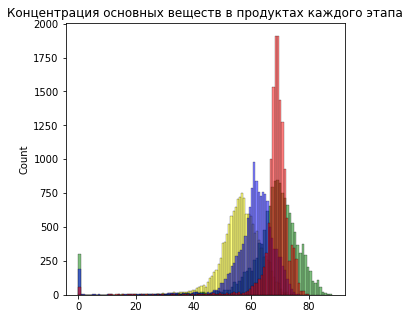

In [47]:
plt.figure(figsize = (5,5))


sns.histplot(rougher_total_feed_train, bins=100, color ='yellow', alpha=.5)
sns.histplot(rougher_total_concentrate_train, bins=100, color ='green', alpha=.5)
sns.histplot(primary_cleaner_total_concentrate_train, bins=100, color='blue', alpha=.5)
sns.histplot(final_total_concentrate_train, bins=100, color='red', alpha=.5)

plt.title('Концентрация основных веществ в продуктах каждого этапа')

plt.show()

На графике видно, что содержание основных веществ в продуктах от этапа к этапу становится больше - т.е. сырье очищается, а также нормализуется — на третьем этапе высокий пик в среднем значении.

Не менее интресно, что за выбросы у нуля — попробуем посмотреть на этот участок графика ближе.

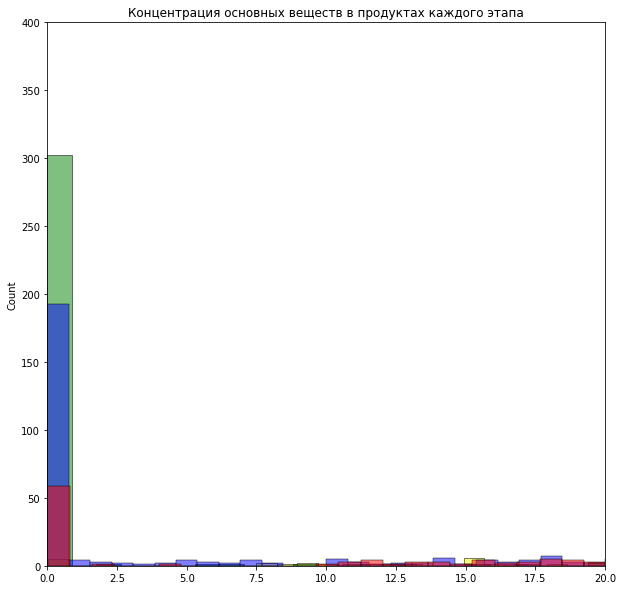

In [50]:
plt.figure(figsize = (10,10))

sns.histplot(rougher_total_feed_train, bins=100, color ='yellow', alpha=.5)
sns.histplot(rougher_total_concentrate_train, bins=100, color ='green', alpha=.5)
sns.histplot(primary_cleaner_total_concentrate_train, bins=100, color='blue', alpha=.5)
sns.histplot(final_total_concentrate_train, bins=100, color='red', alpha=.5)

plt.xlim([0, 20])
plt.ylim([0, 400])

plt.title('Концентрация основных веществ в продуктах каждого этапа')

plt.show()

Суммарный продукт равный нулю — это либо технические запуски установки без сырья, либо какая-то ошибка. Такие аномалии все же стоит отбросить.

Чтобы вычленить эти строки, отбросим объекты с нулевой концентрацией определенных веществ на этапе флотации, а потом еще раз посмотрим на гистограмму распределения

In [51]:
train_data = train_data[train_data['rougher.output.concentrate_au']!=0]
train_data = train_data[train_data['primary_cleaner.output.concentrate_au']!=0]
train_data = train_data[train_data['final.output.concentrate_au']!=0]

In [52]:
# на этапе флотации
    
rougher_total_concentrate_train = (train_data['rougher.output.concentrate_au'] +
                                   train_data['rougher.output.concentrate_ag'] + 
                                   train_data['rougher.output.concentrate_pb'] +
                                   train_data['rougher.output.concentrate_sol'])

# на этапе первичной обработки

primary_cleaner_total_concentrate_train = (train_data['primary_cleaner.output.concentrate_au'] +
                                           train_data['primary_cleaner.output.concentrate_ag'] +
                                           train_data['primary_cleaner.output.concentrate_pb'] +
                                           train_data['primary_cleaner.output.concentrate_sol'])

# финальный концентрат
final_total_concentrate_train = (train_data['final.output.concentrate_au'] +
                                 train_data['final.output.concentrate_ag'] +
                                 train_data['final.output.concentrate_pb'] +
                                 train_data['final.output.concentrate_sol'])

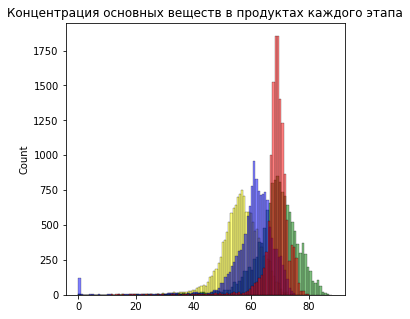

In [53]:
plt.figure(figsize = (5,5))

sns.histplot(rougher_total_feed_train, bins=100, color ='yellow', alpha=.5)
sns.histplot(rougher_total_concentrate_train, bins=100, color ='green', alpha=.5)
sns.histplot(primary_cleaner_total_concentrate_train, bins=100, color='blue', alpha=.5)
sns.histplot(final_total_concentrate_train, bins=100, color='red', alpha=.5)

#plt.xlim([0, 20]) # данные строки можно разкомментировать для приближения масштаба
#plt.ylim([0, 400])

plt.title('Концентрация основных веществ в продуктах каждого этапа')

plt.show()

Пик около нуля остался только для концентрата после первичной очистки, обозначенный синим. На этапе обработки пропусков мы отмечали, что такие же всплески есть и в целевых признаках, как в обучающей, так и в тестовой выборках. Попробуем оставить и  "не вылавливать" объекты с нулевым концентратом, т.к. модель должна обучиться предсказывать и нули.

## Модель

Теперь перед нами стоит задача регрессии: предсказать количественные целевые признаки `rougher.output.recovery` и `final.output.recovery`. 
    

Для построения моделей будут использованы следующие алгоритмы:
- LinearRegression - линейная регрессия;
- DecisionTreeRegressor;
- RandomForestRegressor.

Оценка качетсва модели будет осуществляться путем расчета  **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Причем у  разных этапов будет разный вес в финальном **sMAPE** - 25% у чернового концентрата после флотации и 75% у финального концентрата.

### Функция расчета sMAPE

In [54]:
def smape(target, pred):
    """
    Эта функция считает симметричное среднее абсолютное процентное отклонение.
    На вход функция принимает целевые значения и предсказания модели.
    
    """   
    return ((1/len(target)) * np.sum(2 * np.abs(target - pred) / (np.abs(target) + np.abs(pred)))) * 100

    

В условиях задачи нам нужно посчитать sMAPE для продукта флотации и для финального продукта всего процесса. Определим дополнительную функцию.

In [55]:
def smape_weighed(sMAPE_first, sMAPE_second, first_weight = .25, second_weight = .75):
    """
    Эта функция возвращает "взвешенное" симметричное среднее абсолютное процентное отклонение
    для двух исходных симметричных средних абсолютных процентных отклонениях исходя из их вклада.
    
    За веса отвечают параметры first_weight и second_weight.
    По умолчанию имеют веса 25% и 75% соответственно.
    
    """
    return sMAPE_first * first_weight + sMAPE_second * second_weight

#### sMAPE моделей

Для оценки эффеткивности моделей далее мы будем использовать метрику `.score` по умолчанию (коэффициент детерминации). Однако ниже, за счет импорта `make_scorer`, мы определим новую метрику — при необъожимости ее можно будет передать для выбора модели в GridSearchCV.

In [57]:
smape_score = make_scorer(smape, greater_is_better=False)

### Определение признаков и целевого признака

Наличие пропусков приведет к ошибке при обучении моделей — отбросим их.

In [58]:
train_data = train_data.dropna()
test_data = test_data.dropna()

#### Определение целевых признаков

Целевые признаки поставлены по условию задачи: это эффективность обогащения чернового концентрата `rougher.output.recovery` и  эффективность обогащения финального продукта `final.output.recovery`

In [59]:
target_train_rougher = train_data['rougher.output.recovery']
target_train_final = train_data['final.output.recovery']

target_test_rougher = test_data['rougher.output.recovery']
target_test_final = test_data['final.output.recovery'] 

#### Определение признаков для этапа rougher

В качестве признаков, которые мы будем передавать модели для предсказания целевых признаков определим данные, которые нам известны до начала процесса.

Для финального продукта это параметры типа `rougher.input` — т.е. параметры сырья перед началом флотации, — а также параметры типа `state` на каждом этапе и количество флотационных реагентов в начале первичной очистки.

Для чернового концентрата — параметры типа `input` и `state` для этапа `rouger`.

Создадим цикл, который выберет из всех столбцов тестовой выборки те, в названии которых есть `rougher` — при загрузке данных мы отметили, что там уже нет параметров типа `output` и `calculated`. Этот же список можно будет передать тренировочной выборке для выбора подходящих признаков для обучения модели.

In [60]:
rouger_features_columns = []
for column in test_data.columns:
    if 'rougher' in column:
        rouger_features_columns.append(column)

In [61]:
rouger_features_columns #посмотрим список признаков для предсказания `rougher.output.recovery`

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.output.recovery']

Определяем признаки тестовой выборки для предсказания `rougher.output.recovery`

In [62]:
features_test_rougher = test_data[rouger_features_columns].drop(['rougher.output.recovery'], axis=1)

In [63]:
features_test_rougher.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,...,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807
1,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,...,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514
2,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,...,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340
3,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,...,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986
4,11.327427,4.767383,488.248117,63.315324,41.269161,11.290425,13.607257,5.738081,13.650053,5.739634,...,1304.658848,-399.511519,1306.455515,-399.050685,1248.699349,-400.876894,1058.839106,-398.988239,949.645313,-399.277632


In [64]:
features_test_rougher.shape

(5229, 22)

Аналогично в тренировочной выборке:

In [65]:
features_train_rougher = train_data[rouger_features_columns].drop(['rougher.output.recovery'], axis=1)

In [66]:
features_train_rougher.shape

(10737, 22)

#### Определение признаков для final.output.recovery

Для финального продукта признаки — это все столбцы тестовой выборки, за исключением целевых признаков (которые мы туда присоединили из общей даты ☺).

In [67]:
features_test_final = test_data.drop(['final.output.recovery','rougher.output.recovery','date'], axis=1)

Для тренировочной передадим список столбцов, "вынутый" нами из тестовой выборки.

In [68]:
features_train_final = train_data[features_test_final.columns]

In [69]:
features_train_final

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [70]:
features_test_final.shape

(5229, 52)

In [71]:
target_test_final.shape

(5229,)

In [72]:
features_train_final.shape

(10737, 52)

In [73]:
target_train_final.shape

(10737,)

#### Выводы по определению признаков

Таким образом модель будет обучена на 10737 объектах, и проверена на 5229 объектах. Для предсказания `rougher.output.recovery` будет использовано 22 признака, а для предсказания `final.ouput.recovery` — 52.

### Обучение модели Линейной Регрессии

Обучим модель линейной регрессии и проверим ее качество кросс-валидацией.

Для модели линейной регрессии в качестве метрики используем `smape_score` — его среднее значение мы и получим на выходе.

In [76]:
#для продукта флотации

model = LinearRegression()
cross_val_score(model, features_train_rougher, target_train_rougher, cv=5, scoring =smape_score).mean()

-6.339313090680679

In [77]:
#для финального продукта

model = LinearRegression()
cross_val_score(model, features_train_final, target_train_final,scoring =smape_score, cv=5).mean()

-9.018601124709146

На качество предсказания моделей, обученных по алгоритму линейной регресии может влиять различный мастшаб признаков — попробуем нормализовать данные и сравнить результат.

In [78]:
model = LinearRegression()

scaled_features_train_final = scale(features_train_final)

cross_val_score(model, scaled_features_train_final, target_train_final, scoring =smape_score, cv=5).mean()

-9.018601124709138

Нормализация не помогла, а линейная регрессия очевидно не справляется.

### Регрессия с помощью древа принятия решения

Для построения модели регрессии DecisionTreeRegressor применим GridSearchCV — как следует из названия в нем уже "зашита" кросс-валидация.

In [79]:
model = DecisionTreeRegressor(random_state = 800)

In [80]:
# создаем словарь с параметрами для регрессора

parametrs = {'max_depth' : range(1,20,2),
             'min_samples_leaf': range (1,8),
             'min_samples_split': range (2,10,2)}

In [83]:
grid = GridSearchCV(model, parametrs,  scoring = smape_score, cv=5)
grid.fit(features_train_rougher, target_train_rougher)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=800),
             param_grid={'max_depth': range(1, 20, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2)},
             scoring=make_scorer(smape, greater_is_better=False))

In [84]:
grid.best_params_ # модель с лучшими предсказаниями

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [86]:
# создаем и обучаем модель с нужными параметрами
model = DecisionTreeRegressor(max_depth= 3,
                              min_samples_leaf = 1,
                              min_samples_split = 2,
                              random_state = 800)

model.fit(features_train_rougher, target_train_rougher)
smape_score(model, features_test_rougher, target_test_rougher)

-7.875214608177567

Качество модели все еще очень низкое. Попробуем использовать модель для финального продукта.

In [87]:
model = DecisionTreeRegressor(random_state = 800)
grid = GridSearchCV(model, parametrs, scoring = smape_score, cv=5)
grid.fit(features_train_final, target_train_final)
grid.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [88]:
# создаем и обучаем модель с нужными параметрами
model = DecisionTreeRegressor(max_depth= 1,
                              min_samples_leaf = 1,
                              min_samples_split = 2,
                              random_state = 800)

model.fit(features_train_final, target_train_final)
smape_score(model, features_train_final, target_train_final)

-7.888373608383762

Модель все еще не справляется. Коэффициент детерминации 0.17 это не очень хорошо, но уже что-то.

### Регрессия с помощью RandomForestRegressor

Как и в случае с решающим древом, воспользуемся GridSearchCV

In [89]:
model = RandomForestRegressor(random_state = 800)

parametrs = {'n_estimators' : range(10,100,20),
             'min_samples_split' : range(2,6,1)}

grid = GridSearchCV(model, parametrs, scoring = smape_score, cv=5)
grid.fit(features_train_rougher, target_train_rougher)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=800),
             param_grid={'min_samples_split': range(2, 6),
                         'n_estimators': range(10, 100, 20)},
             scoring=make_scorer(smape, greater_is_better=False))

In [91]:
# создаем и обучаем модель с нужными параметрами
model = RandomForestRegressor(n_estimators = 50,
                              min_samples_split = 2,
                              random_state = 800)

model.fit(features_train_rougher, target_train_rougher)
smape_score(model, features_test_rougher, target_test_rougher)

-8.019607217317956

In [92]:
model = RandomForestRegressor(random_state = 800)

parametrs = {'n_estimators' : range(10,100,20),
             'min_samples_split' : range(2,6,1)}

grid = GridSearchCV(model, parametrs, scoring = smape_score, cv=5)
grid.fit(features_train_final, target_train_final)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=800),
             param_grid={'min_samples_split': range(2, 6),
                         'n_estimators': range(10, 100, 20)},
             scoring=make_scorer(smape, greater_is_better=False))

In [94]:
grid.best_params_

{'min_samples_split': 3, 'n_estimators': 90}

Для предсказания финального продукта гиперпаметры лучше поменять.

In [95]:
# создаем и обучаем модель с нужными параметрами
model = RandomForestRegressor(n_estimators = 90,
                              min_samples_split = 3,
                              random_state = 800)

model.fit(features_train_final, target_train_final)
model.score(features_train_final, target_train_final)

0.9476520863263731

Коэффициент детерминации снова близок к единице — можель предсказывает почти безошибочно.

In [96]:
smape_score(model, features_train_final, target_train_final)

-1.835918098997631

### Расчет sMAPE для лучшей модели

Настало время показать лучшей модели предсказания тестовую выборку и посмотреть какое значение целевой метрики sMAPE мы получим. Для этого:
- обучим модель для предсказания `rougher.ouput.recovery` и сохраним ее предсказания на тестовой выборке;
- рассчитаем sMAPE для этапа флотации;
- обучим модель для предсказания `final.output.recovery`, сохраним ее предсказания на тестовой выборке;
- рассчитаем sMAPE для общего технологического процесса;
- рассчитаем финальный sMAPE исходя из весов каждого этапа.

In [97]:
# обучаем модель Случайного леса с лучшими гиперпараметрами для этапа флотации

model = RandomForestRegressor(n_estimators = 50,
                              min_samples_split = 2,
                              random_state = 800)              # создаем объект модели

model.fit(features_train_rougher, target_train_rougher)        # обучаем на тренировочной выборке
rougher_predictions = model.predict(features_test_rougher)         # сохраняем предсказания

rougher_smape =smape(target_test_rougher, rougher_predictions)

In [98]:
# обучаем модель Случайного леса с лучшими гиперпараметрами для всего процесса

model = RandomForestRegressor(n_estimators = 90,
                              min_samples_split = 3,
                              random_state = 800)              # создаем объект модели

model.fit(features_train_final, target_train_final)            # обучаем на тренировочной выборке
final_predictions = model.predict(features_test_final)     # сохраняем предсказания

final_smape =smape(target_test_final, final_predictions)

In [99]:
rougher_smape

8.019607217317956

In [100]:
final_smape

9.745902389087526

In [101]:
best_model_smape = smape_weighed(rougher_smape,final_smape)
best_model_smape

9.314328596145133

Итоговый sMAPE для лучшей модели равен `9.3 %` — т.е модель может ошибаться в среднем на 9,3 % — кажется, неплохая точность?

Сравним нашу модель с константной моделью, предсказывающей для всех объектов среднее значение.

In [102]:
dummy_regr = DummyRegressor(strategy="mean") #константная модель

#обучаем для продукта флотации

dummy_regr.fit(features_train_rougher, target_train_rougher)

#сохраянем предсказания на флотации
rougher_predictions_dummy  = dummy_regr.predict(features_test_rougher)  

#считаем smape
rougher_smape_dummy =smape(target_test_rougher, rougher_predictions_dummy)

#повторяем для final

dummy_regr.fit(features_train_final, target_train_final)

final_predictions_dummy  = dummy_regr.predict(features_test_final)  

final_smape_dummy =smape(target_test_final, final_predictions_dummy)

In [103]:
dummy_model_smape = smape_weighed(rougher_smape_dummy,final_smape_dummy)
dummy_model_smape

9.336557219082437

## Вывод по работе

Целью работы было построить модель, которая бы предсказывала коэффициенты обогащения золотой руды после флотации и после всего технологического процесса, включающего в себя также две очистки.

В начале мы загрузили общие данные, тренировочную и тестовую выборку. При просмотре математической статистики выборок было замечено, что у многих признаков отличаются значенения средних и дисперсий, что говорит о большом разбросе признаков и непостоянстве входного сырья. 

В ходе предобработки данных были замечены объекты, у которых доля основных металлов в концентрате была равна 0 — предположительно, это были технологические запуски без руды. Такие объекты мы отбросили перед обучением моделей.

Кроме того, мы проверили концентрации металлов на разных этапах - и отметили, что по ходу технологического процесса доля золота растет, а примесей сокращается.

Перед обучением модели мы также сравнили размеры гранул в тренировочной и тестовой выборках, так чтобы не было ошибки в обучении.

После этого, мы обучили несколько моделей регресии. Лучший результат дала модель случайного леса — при чем для разных целевых признаков, мы использовали разные гиперпараметры.

Выбрав лучшую модель, мы оценили точность ее работы с помощью метрики симметричного среднее абсолютного процентного отклонения.